In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import silhouette_score  # Only for evaluation, not model building
from sklearn.manifold import TSNE  # Only for visualization, not model building

class KMeans:
    def __init__(self, n_clusters=3, init_method='random', max_iter=100, tol=1e-4, random_state=None):
        """
        K-Means clustering algorithm implementation from scratch
        
        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters to form
        init_method : str, default='random'
            Method for initialization, 'random' or 'kmeans++'
        max_iter : int, default=100
            Maximum number of iterations
        tol : float, default=1e-4
            Tolerance to declare convergence
        random_state : int, default=None
            Random state for reproducibility
        """
        self.n_clusters = n_clusters
        self.init_method = init_method
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_ = None  # Sum of squared distances to closest centroid
        self.iterations = 0  # Track number of iterations until convergence
        
    def _initialize_centroids(self, X):
        """Initialize the centroids using the specified method"""
        if self.random_state is not None:
            np.random.seed(self.random_state)
            random.seed(self.random_state)
            
        n_samples, n_features = X.shape
        centroids = np.zeros((self.n_clusters, n_features))
        
        if self.init_method == 'random':
            # Randomly select k data points as initial centroids
            indices = random.sample(range(n_samples), self.n_clusters)
            centroids = X[indices]
        
        elif self.init_method == 'kmeans++':
            # Select first centroid randomly
            first_centroid_idx = random.randint(0, n_samples-1)
            centroids[0] = X[first_centroid_idx]
            
            # Select the rest of the centroids
            for i in range(1, self.n_clusters):
                # Calculate distances from points to the existing centroids
                distances = np.array([min([np.linalg.norm(x - centroid)**2 for centroid in centroids[:i]]) for x in X])
                
                # Normalize to create a probability distribution
                probs = distances / distances.sum()
                
                # Choose the next centroid using the weighted probabilities
                next_centroid_idx = np.random.choice(range(n_samples), p=probs)
                centroids[i] = X[next_centroid_idx]
                
        return centroids
    
    def _assign_clusters(self, X):
        """Assign each sample to the nearest centroid"""
        n_samples = X.shape[0]
        labels = np.zeros(n_samples, dtype=int)
        distances = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Calculate distance to each centroid
            sample_distances = [np.linalg.norm(X[i] - centroid) for centroid in self.centroids]
            # Assign to the closest centroid
            labels[i] = np.argmin(sample_distances)
            # Store the distance to the closest centroid
            distances[i] = min(sample_distances) ** 2
            
        # Calculate inertia (sum of squared distances to closest centroid)
        inertia = np.sum(distances)
        
        return labels, inertia
    
    def _update_centroids(self, X, labels):
        """Update centroids based on assigned clusters"""
        n_features = X.shape[1]
        new_centroids = np.zeros((self.n_clusters, n_features))
        
        for i in range(self.n_clusters):
            # Get points assigned to cluster i
            cluster_points = X[labels == i]
            # If cluster is empty, keep the old centroid
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[i] = self.centroids[i]
                
        return new_centroids
    
    def fit(self, X):
        """Fit the K-means model to the data"""
        # Initialize centroids
        self.centroids = self._initialize_centroids(X)
        prev_centroids = np.zeros_like(self.centroids)
        
        # Track convergence
        converged = False
        self.iterations = 0
        
        for it in range(self.max_iter):
            # Assign data points to clusters
            self.labels, self.inertia_ = self._assign_clusters(X)
            
            # Store previous centroids for convergence check
            prev_centroids = self.centroids.copy()
            
            # Update centroids
            self.centroids = self._update_centroids(X, self.labels)
            
            # Increment iteration counter
            self.iterations += 1
            
            # Check for convergence
            centroid_shift = np.linalg.norm(self.centroids - prev_centroids)
            if centroid_shift < self.tol:
                converged = True
                break
                
        return self
    
    def predict(self, X):
        """Predict the closest cluster for each sample in X"""
        labels, _ = self._assign_clusters(X)
        return labels


def run_kmeans_with_metrics(X, k_values, init_method='random', n_runs=5, random_state=42):
    """
    Run K-means for different values of k and calculate performance metrics
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        The input data
    k_values : list
        List of k values to try
    init_method : str, default='random'
        Initialization method ('random' or 'kmeans++')
    n_runs : int, default=5
        Number of runs for each k value
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    results : dict
        Dictionary with results for each k value
    """
    results = {
        'k_values': k_values,
        'inertia': [],
        'inertia_std': [],
        'silhouette': [],
        'silhouette_std': [],
        'iterations': [],
        'iterations_std': [],
        'time': [],
        'time_std': [],
        'labels': [],
        'centroids': []
    }
    
    for k in k_values:
        k_inertia = []
        k_silhouette = []
        k_iterations = []
        k_time = []
        k_labels = []
        k_centroids = []
        
        for run in range(n_runs):
            run_seed = random_state + run
            
            # Time the execution
            start_time = time.time()
            
            # Create and fit K-means
            kmeans = KMeans(n_clusters=k, init_method=init_method, random_state=run_seed)
            kmeans.fit(X)
            
            # Record execution time
            execution_time = time.time() - start_time
            k_time.append(execution_time)
            
            # Record inertia
            k_inertia.append(kmeans.inertia_)
            
            # Record iterations
            k_iterations.append(kmeans.iterations)
            
            # Calculate silhouette score if k >= 2
            if k >= 2:
                score = silhouette_score(X, kmeans.labels)
                k_silhouette.append(score)
            else:
                k_silhouette.append(0)  # Assign 0 for k=1
                
            # Save labels and centroids for the first run
            if run == 0:
                k_labels.append(kmeans.labels)
                k_centroids.append(kmeans.centroids)
        
        # Store average results for this k
        results['inertia'].append(np.mean(k_inertia))
        results['inertia_std'].append(np.std(k_inertia))
        results['silhouette'].append(np.mean(k_silhouette))
        results['silhouette_std'].append(np.std(k_silhouette))
        results['iterations'].append(np.mean(k_iterations))
        results['iterations_std'].append(np.std(k_iterations))
        results['time'].append(np.mean(k_time))
        results['time_std'].append(np.std(k_time))
        results['labels'].append(k_labels[0])  # Save labels from first run
        results['centroids'].append(k_centroids[0])  # Save centroids from first run
        
    return results


def visualize_metrics(random_results, kmeans_pp_results, k_values):
    """
    Visualize clustering metrics for both initialization methods
    
    Parameters:
    -----------
    random_results : dict
        Results from random initialization
    kmeans_pp_results : dict
        Results from k-means++ initialization
    k_values : list
        List of k values used
    """
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot inertia (elbow method)
    axes[0, 0].errorbar(k_values, random_results['inertia'], 
                       yerr=random_results['inertia_std'], 
                       fmt='o-', label='Random Init')
    axes[0, 0].errorbar(k_values, kmeans_pp_results['inertia'], 
                       yerr=kmeans_pp_results['inertia_std'], 
                       fmt='s-', label='K-means++ Init')
    axes[0, 0].set_title('Elbow Method (Inertia)', fontsize=14)
    axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0, 0].set_ylabel('Inertia (Sum of Squared Errors)', fontsize=12)
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    axes[0, 0].legend()

    
    # Plot silhouette score
    axes[0, 1].errorbar(k_values, random_results['silhouette'], 
                       yerr=random_results['silhouette_std'], 
                       fmt='o-', label='Random Init')
    axes[0, 1].errorbar(k_values, kmeans_pp_results['silhouette'], 
                       yerr=kmeans_pp_results['silhouette_std'], 
                       fmt='s-', label='K-means++ Init')
    axes[0, 1].set_title('Silhouette Score', fontsize=14)
    axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)
    axes[0, 1].legend()
    
    # Plot iterations until convergence
    axes[1, 0].errorbar(k_values, random_results['iterations'], 
                       yerr=random_results['iterations_std'], 
                       fmt='o-', label='Random Init')
    axes[1, 0].errorbar(k_values, kmeans_pp_results['iterations'], 
                       yerr=kmeans_pp_results['iterations_std'], 
                       fmt='s-', label='K-means++ Init')
    axes[1, 0].set_title('Iterations Until Convergence', fontsize=14)
    axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1, 0].set_ylabel('Number of Iterations', fontsize=12)
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    axes[1, 0].legend()
    
    # Plot execution time
    axes[1, 1].errorbar(k_values, random_results['time'], 
                       yerr=random_results['time_std'], 
                       fmt='o-', label='Random Init')
    axes[1, 1].errorbar(k_values, kmeans_pp_results['time'], 
                       yerr=kmeans_pp_results['time_std'], 
                       fmt='s-', label='K-means++ Init')
    axes[1, 1].set_title('Execution Time', fontsize=14)
    axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


def visualize_clusters_2d(X, labels, centroids, features, title, k):
    """
    Visualize clusters using scatter plots for 2D projections of the data
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        The input data
    labels : array-like, shape (n_samples,)
        Cluster labels for each sample
    centroids : array-like, shape (n_clusters, n_features)
        Cluster centroids
    features : list
        List of feature names
    title : str
        Plot title
    k : int
        Number of clusters
    """
    n_features = X.shape[1]
    n_plots = min(6, (n_features * (n_features - 1)) // 2)  # Limit to 6 plots
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Generate color map
    colors = plt.cm.viridis(np.linspace(0, 1, k))
    
    # Plot feature pairs
    plot_count = 0
    for i in range(n_features):
        for j in range(i+1, n_features):
            if plot_count >= n_plots:
                break
                
            ax = axes[plot_count]
            
            # Plot points colored by cluster
            for cluster_idx in range(k):
                cluster_points = X[labels == cluster_idx]
                ax.scatter(cluster_points[:, i], cluster_points[:, j], 
                          s=50, alpha=0.7, c=[colors[cluster_idx]], 
                          label=f'Cluster {cluster_idx}')
            
            # Plot centroids
            ax.scatter(centroids[:, i], centroids[:, j], 
                      marker='X', s=200, c='red', 
                      edgecolors='black', linewidth=2, 
                      label='Centroids')
            
            ax.set_xlabel(features[i], fontsize=12)
            ax.set_ylabel(features[j], fontsize=12)
            ax.set_title(f'{features[i]} vs {features[j]}', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.3)
            
            plot_count += 1
    
    # Add legend to the last plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
              ncol=k+1, fontsize=12)
    
    # Hide unused subplots
    for i in range(plot_count, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'{title} (k={k})', fontsize=16)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()


def visualize_tsne(X, labels, centroids, title, k):
    """
    Visualize clusters using t-SNE dimensionality reduction
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        The input data
    labels : array-like, shape (n_samples,)
        Cluster labels for each sample
    centroids : array-like, shape (n_clusters, n_features)
        Cluster centroids
    title : str
        Plot title
    k : int
        Number of clusters
    """
    # Apply t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    centroids_tsne = np.array([X_tsne[labels == i].mean(axis=0) for i in range(k)])

    
    # Create scatter plot
    plt.figure(figsize=(12, 10))
    
    # Generate color map
    colors = plt.cm.viridis(np.linspace(0, 1, k))
    
    # Plot points colored by cluster
    for cluster_idx in range(k):
        cluster_points = X_tsne[labels == cluster_idx]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   s=70, alpha=0.7, c=[colors[cluster_idx]], 
                   label=f'Cluster {cluster_idx}')
    
    # Plot centroids
    plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], 
               marker='X', s=300, c='red', 
               edgecolors='black', linewidth=2, 
               label='Centroids')
    
    plt.title(f'{title} (k={k})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


def compare_results_table(random_results, kmeans_pp_results, k_values):
    """
    Create a table comparing random initialization and k-means++ initialization
    
    Parameters:
    -----------
    random_results : dict
        Results from random initialization
    kmeans_pp_results : dict
        Results from k-means++ initialization
    k_values : list
        List of k values used
        
    Returns:
    --------
    comparison_df : pandas.DataFrame
        DataFrame with comparison results
    """
    # Create empty lists to store data
    data = []
    
    for i, k in enumerate(k_values):
        row = {
            'k': k,
            'Random Inertia': f"{random_results['inertia'][i]:.2f} ± {random_results['inertia_std'][i]:.2f}",
            'K-means++ Inertia': f"{kmeans_pp_results['inertia'][i]:.2f} ± {kmeans_pp_results['inertia_std'][i]:.2f}",
            'Random Silhouette': f"{random_results['silhouette'][i]:.4f} ± {random_results['silhouette_std'][i]:.4f}",
            'K-means++ Silhouette': f"{kmeans_pp_results['silhouette'][i]:.4f} ± {kmeans_pp_results['silhouette_std'][i]:.4f}",
            'Random Iterations': f"{random_results['iterations'][i]:.1f} ± {random_results['iterations_std'][i]:.1f}",
            'K-means++ Iterations': f"{kmeans_pp_results['iterations'][i]:.1f} ± {kmeans_pp_results['iterations_std'][i]:.1f}",
            'Random Time(s)': f"{random_results['time'][i]:.4f} ± {random_results['time_std'][i]:.4f}",
            'K-means++ Time(s)': f"{kmeans_pp_results['time'][i]:.4f} ± {kmeans_pp_results['time_std'][i]:.4f}"
        }
        data.append(row)
    
    # Create DataFrame
    comparison_df = pd.DataFrame(data)
    return comparison_df


def calculate_cluster_stability(X, k, init_method, n_runs=10, random_state=42):
    """
    Calculate cluster stability by measuring agreement between different runs
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        The input data
    k : int
        Number of clusters
    init_method : str
        Initialization method ('random' or 'kmeans++')
    n_runs : int, default=10
        Number of runs
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    stability : float
        Stability score (higher is better)
    """
    n_samples = X.shape[0]
    
    # Run K-means multiple times
    all_labels = []
    for run in range(n_runs):
        kmeans = KMeans(n_clusters=k, init_method=init_method, random_state=random_state + run)
        kmeans.fit(X)
        all_labels.append(kmeans.labels)
    
    # Create a co-occurrence matrix
    cooccurrence = np.zeros((n_samples, n_samples))
    
    # Fill co-occurrence matrix
    for labels in all_labels:
        for i in range(n_samples):
            for j in range(i, n_samples):
                if labels[i] == labels[j]:
                    cooccurrence[i, j] += 1
                    if i != j:
                        cooccurrence[j, i] += 1
    
    # Normalize by number of runs
    cooccurrence /= n_runs
    
    # Calculate stability as average of non-diagonal elements
    # Higher values mean more consistent clustering
    mask = ~np.eye(n_samples, dtype=bool)
    stability = np.mean(cooccurrence[mask])
    
    return stability


def compare_stability(X, k_values, n_runs=10, random_state=42):
    """
    Compare stability of random initialization and k-means++ initialization
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        The input data
    k_values : list
        List of k values to try
    n_runs : int, default=10
        Number of runs for each method
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    stability_df : pandas.DataFrame
        DataFrame with stability comparison
    """
    stability_data = []
    
    for k in k_values:
        random_stability = calculate_cluster_stability(X, k, 'random', n_runs, random_state)
        kmeans_pp_stability = calculate_cluster_stability(X, k, 'kmeans++', n_runs, random_state)
        
        stability_data.append({
            'k': k,
            'Random Stability': random_stability,
            'K-means++ Stability': kmeans_pp_stability,
            'Difference': kmeans_pp_stability - random_stability
        })
    
    stability_df = pd.DataFrame(stability_data)
    return stability_df

Running K-means with random initialization...
Running K-means with k-means++ initialization...
Visualizing comparison metrics...


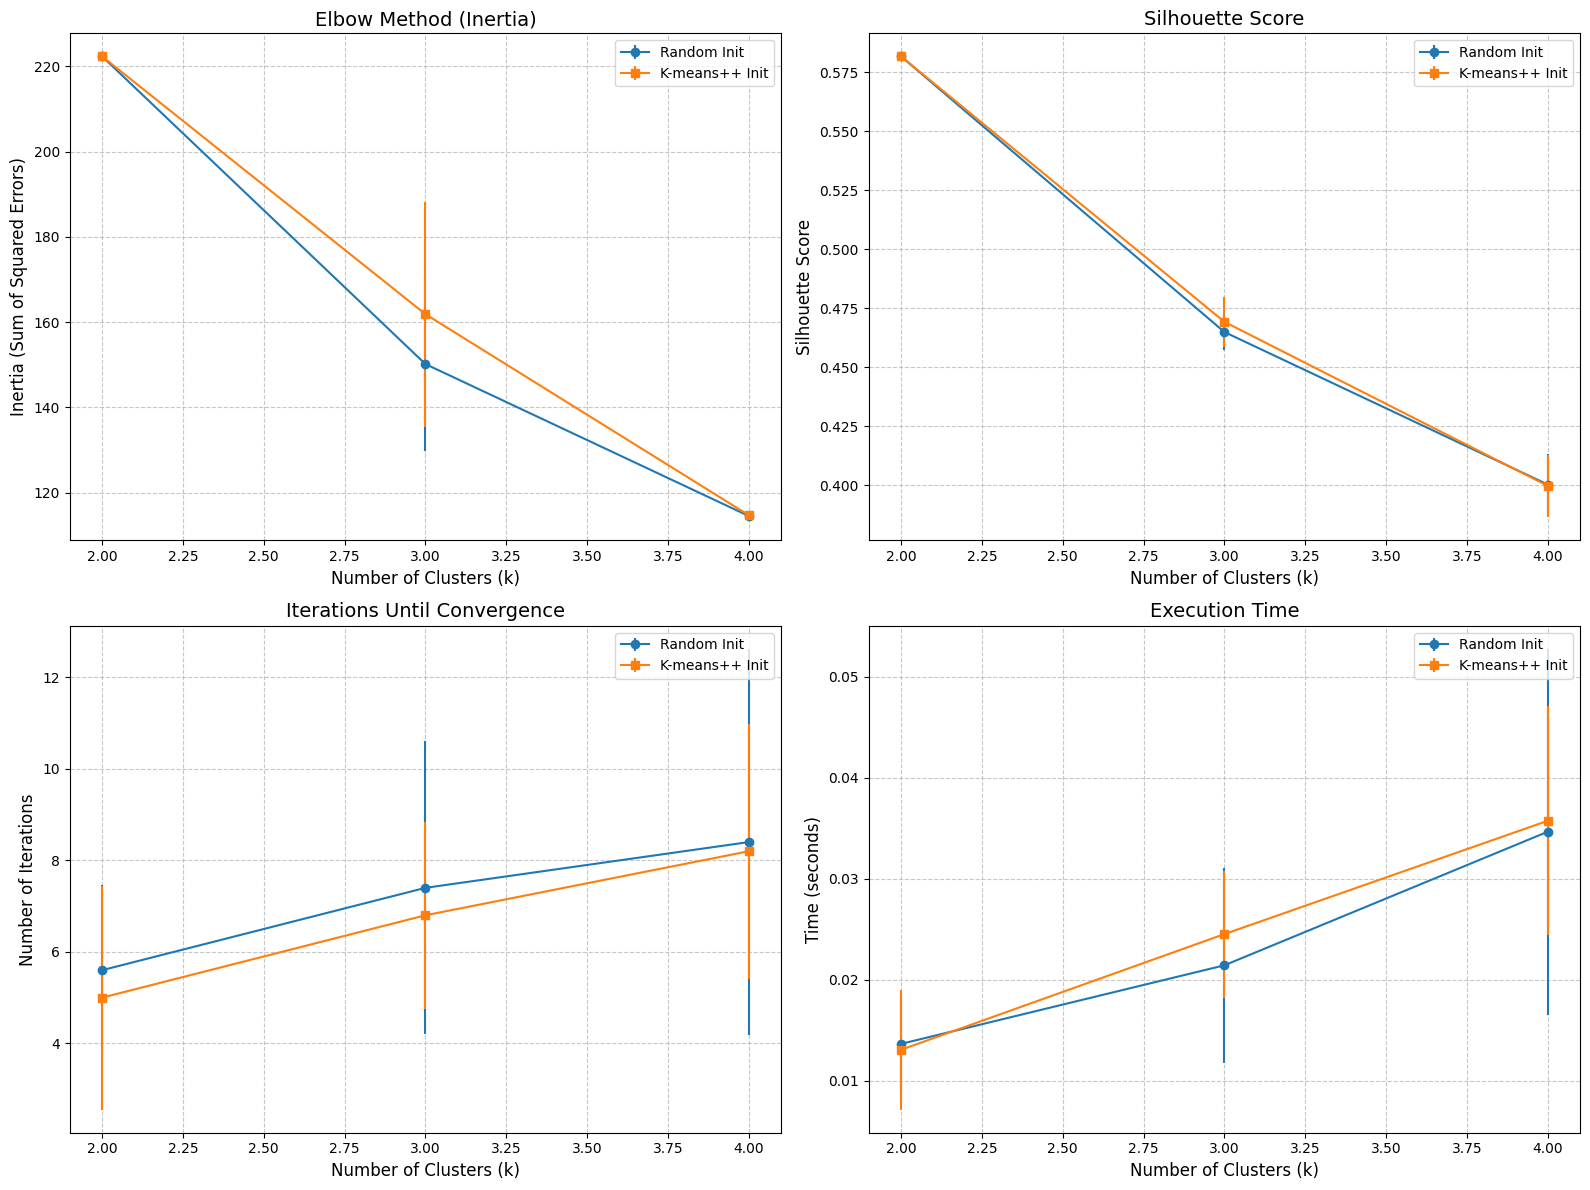

Creating comparison table...

Comparison of Random Initialization vs K-means++ Initialization:
   k  Random Inertia K-means++ Inertia Random Silhouette K-means++ Silhouette  \
0  2   222.36 ± 0.00     222.36 ± 0.00   0.5818 ± 0.0000      0.5818 ± 0.0000   
1  3  150.15 ± 20.44    161.85 ± 26.45   0.4649 ± 0.0076      0.4693 ± 0.0106   
2  4   114.49 ± 0.28     114.68 ± 0.38   0.4003 ± 0.0130      0.3997 ± 0.0133   

  Random Iterations K-means++ Iterations   Random Time(s) K-means++ Time(s)  
0         5.6 ± 1.9            5.0 ± 2.4  0.0137 ± 0.0047   0.0131 ± 0.0059  
1         7.4 ± 3.2            6.8 ± 2.0  0.0214 ± 0.0096   0.0245 ± 0.0063  
2         8.4 ± 4.2            8.2 ± 2.8  0.0346 ± 0.0181   0.0357 ± 0.0113  
Calculating cluster stability...

Cluster Stability Comparison:
   k  Random Stability  K-means++ Stability  Difference
0  2          0.552573             0.552573    0.000000
1  3          0.359338             0.394577    0.035239
2  4          0.274899             0

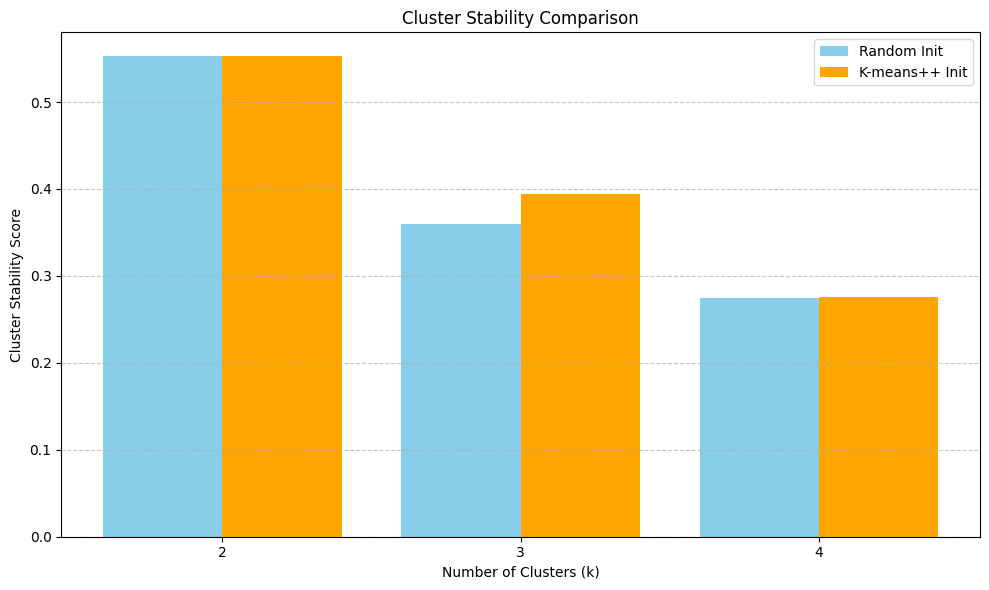


Visualizing clusters for k=2 with random initialization...


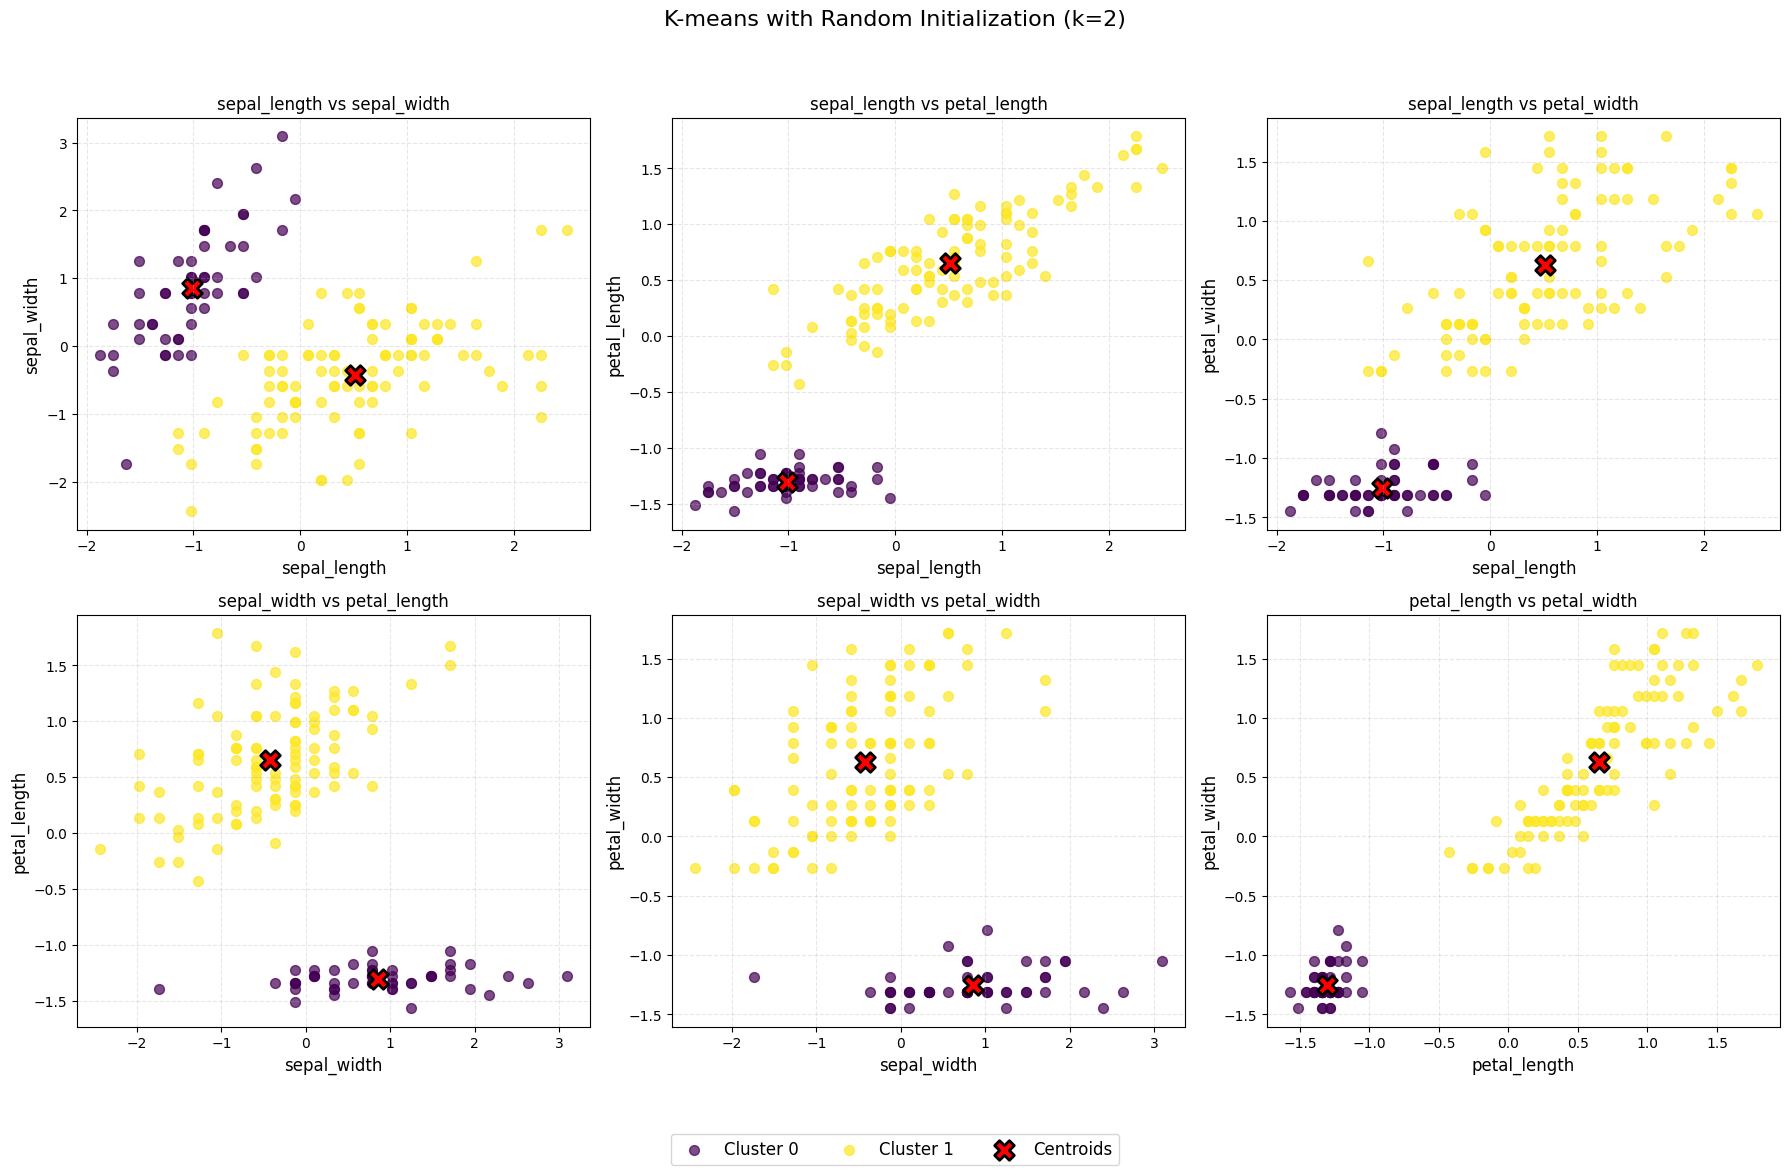

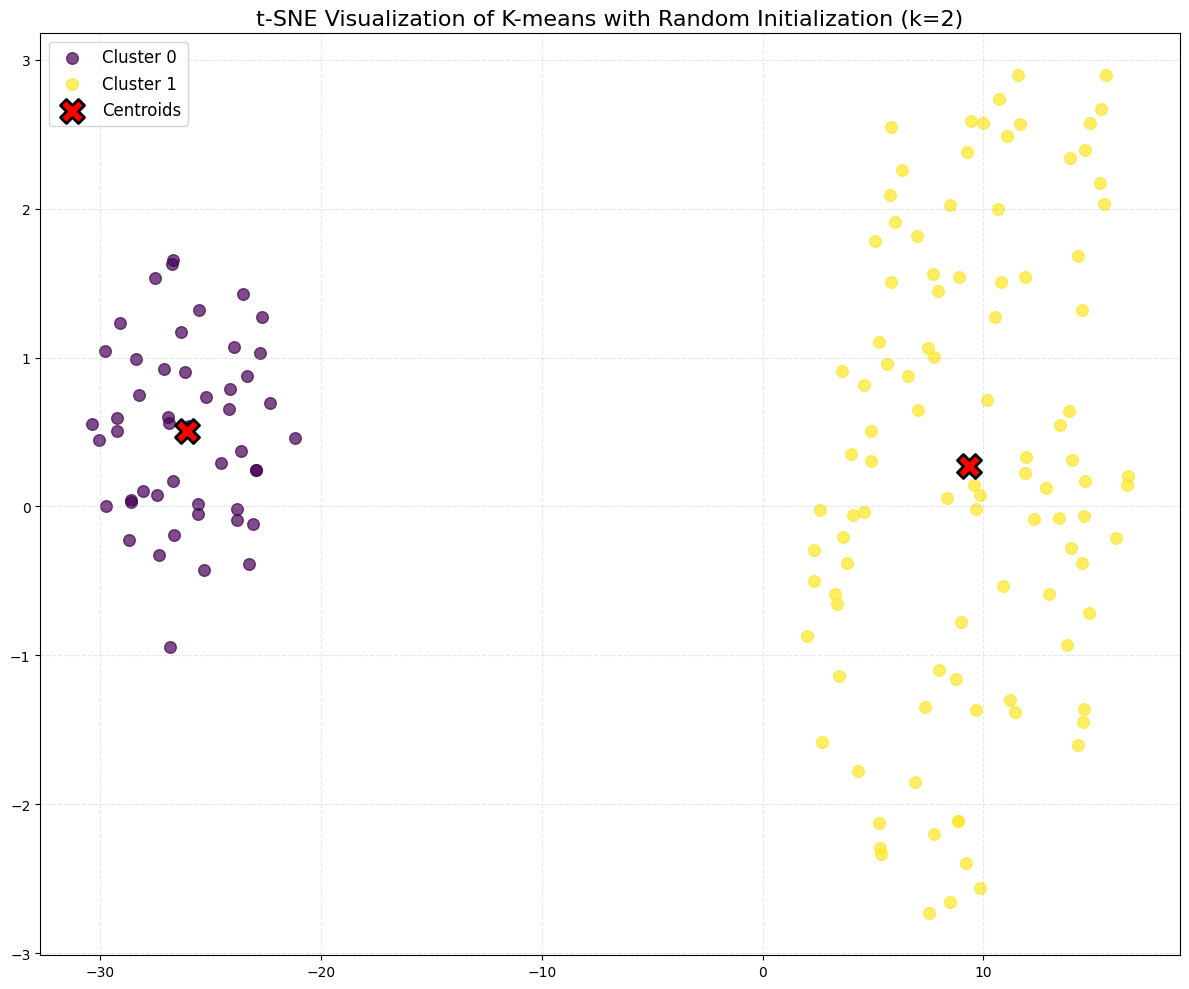


Visualizing clusters for k=2 with k-means++ initialization...


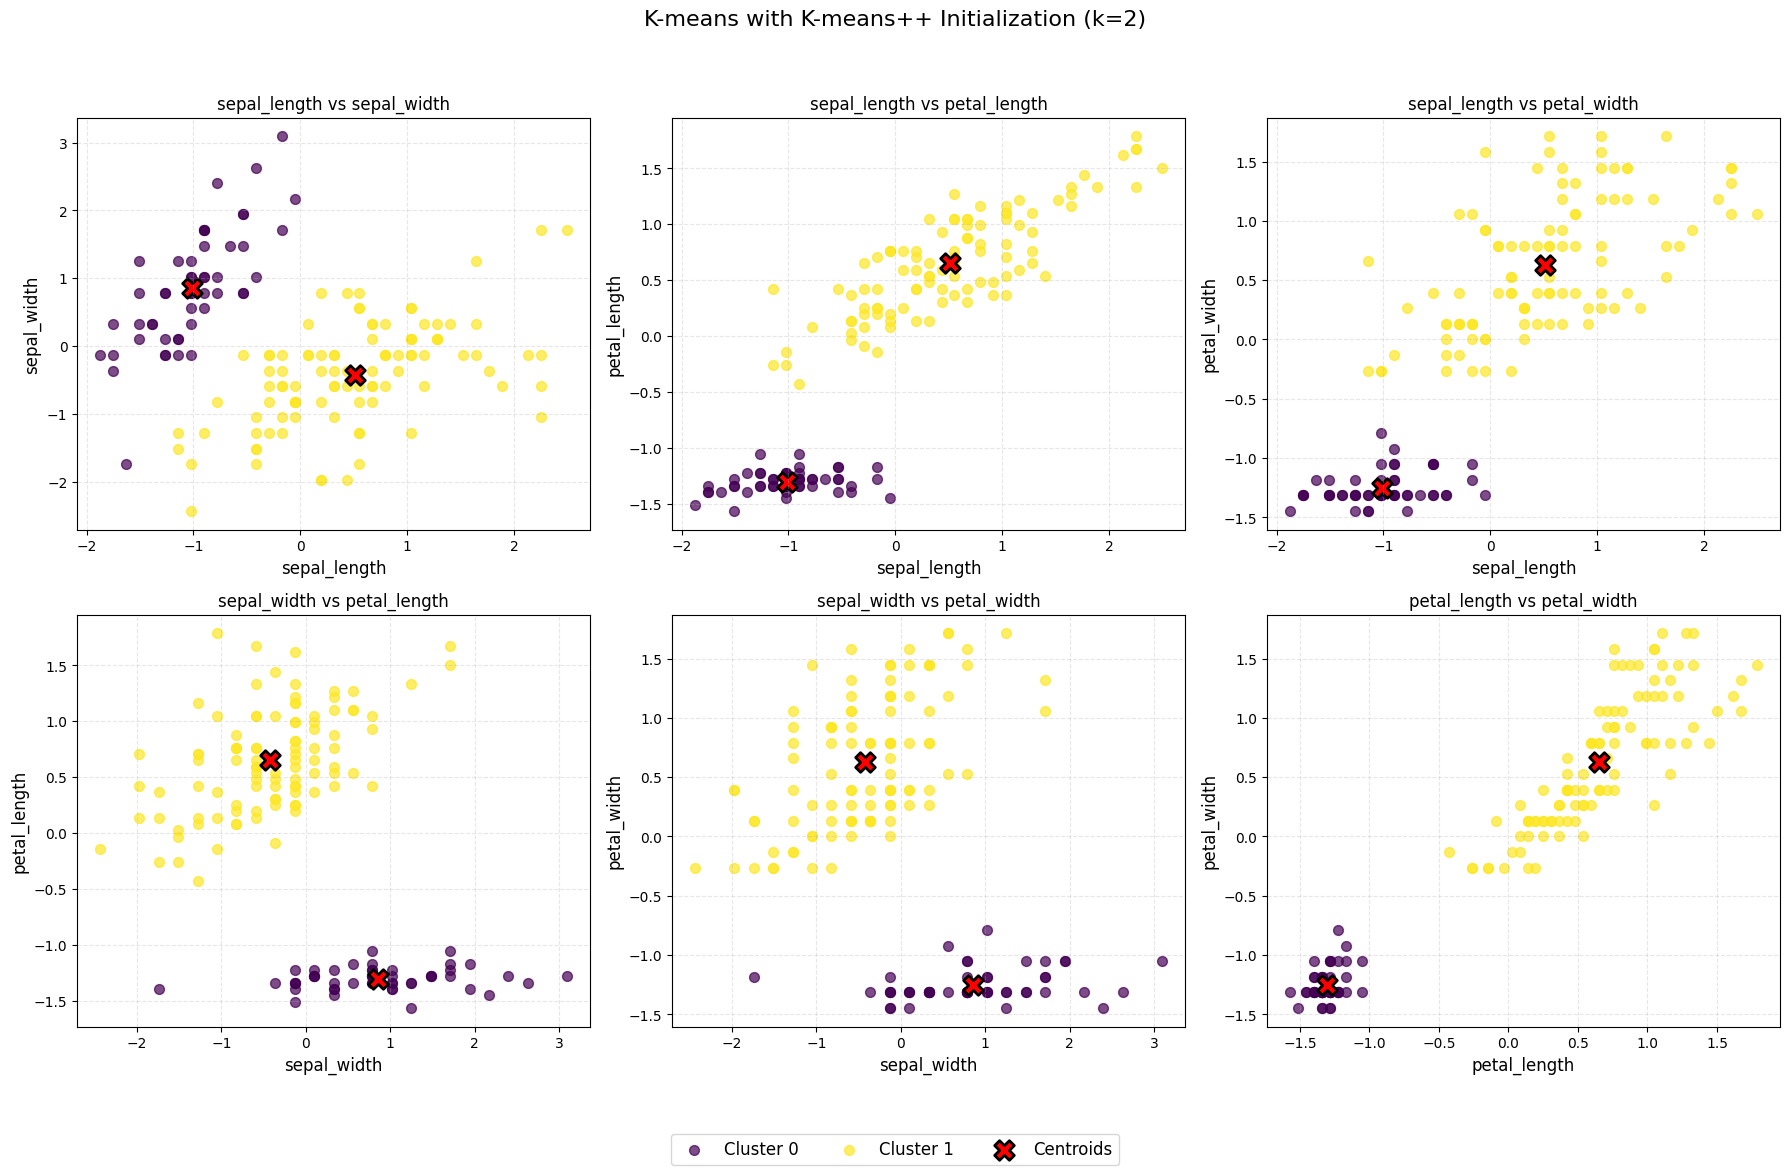

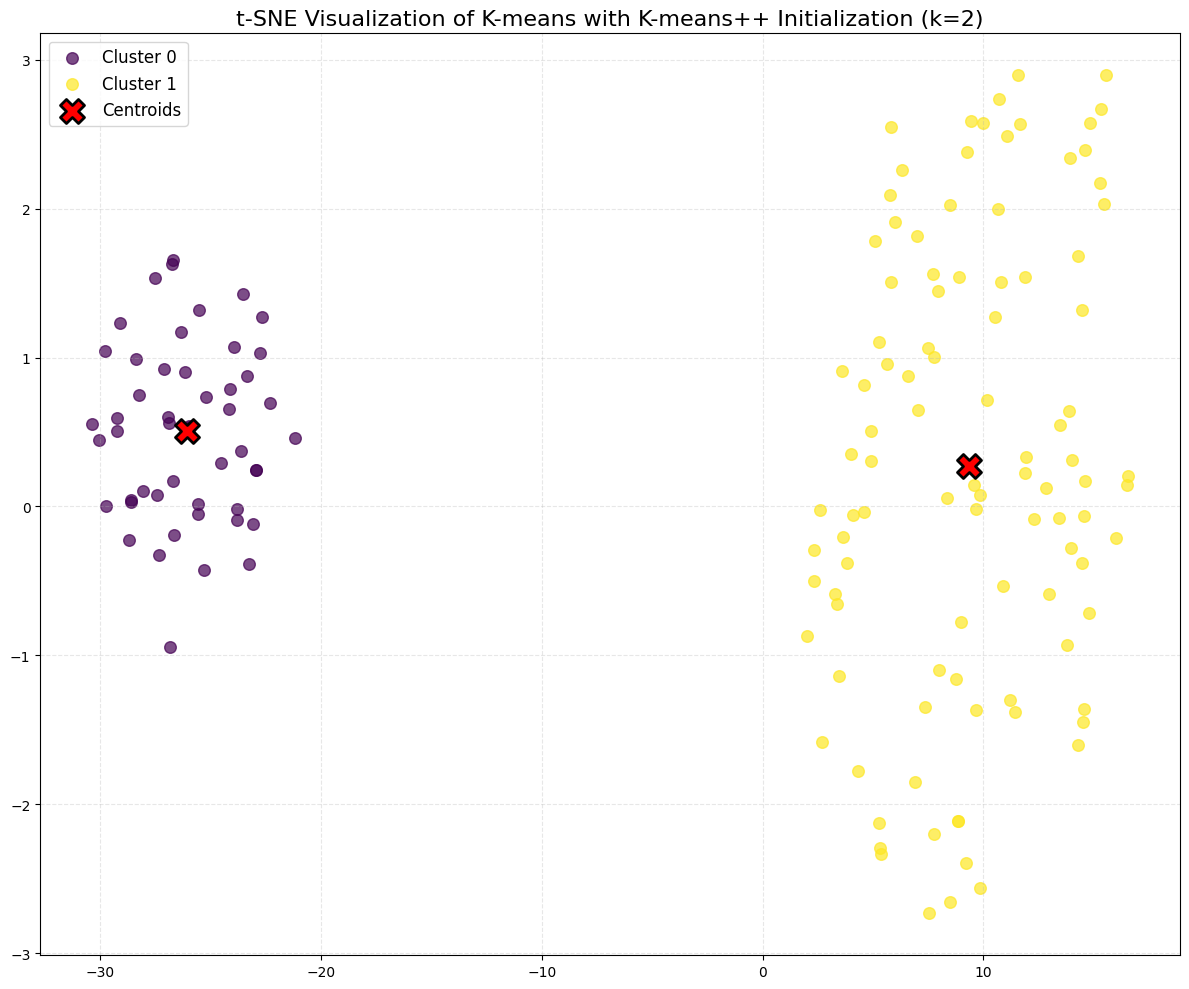


Visualizing clusters for k=3 with random initialization...


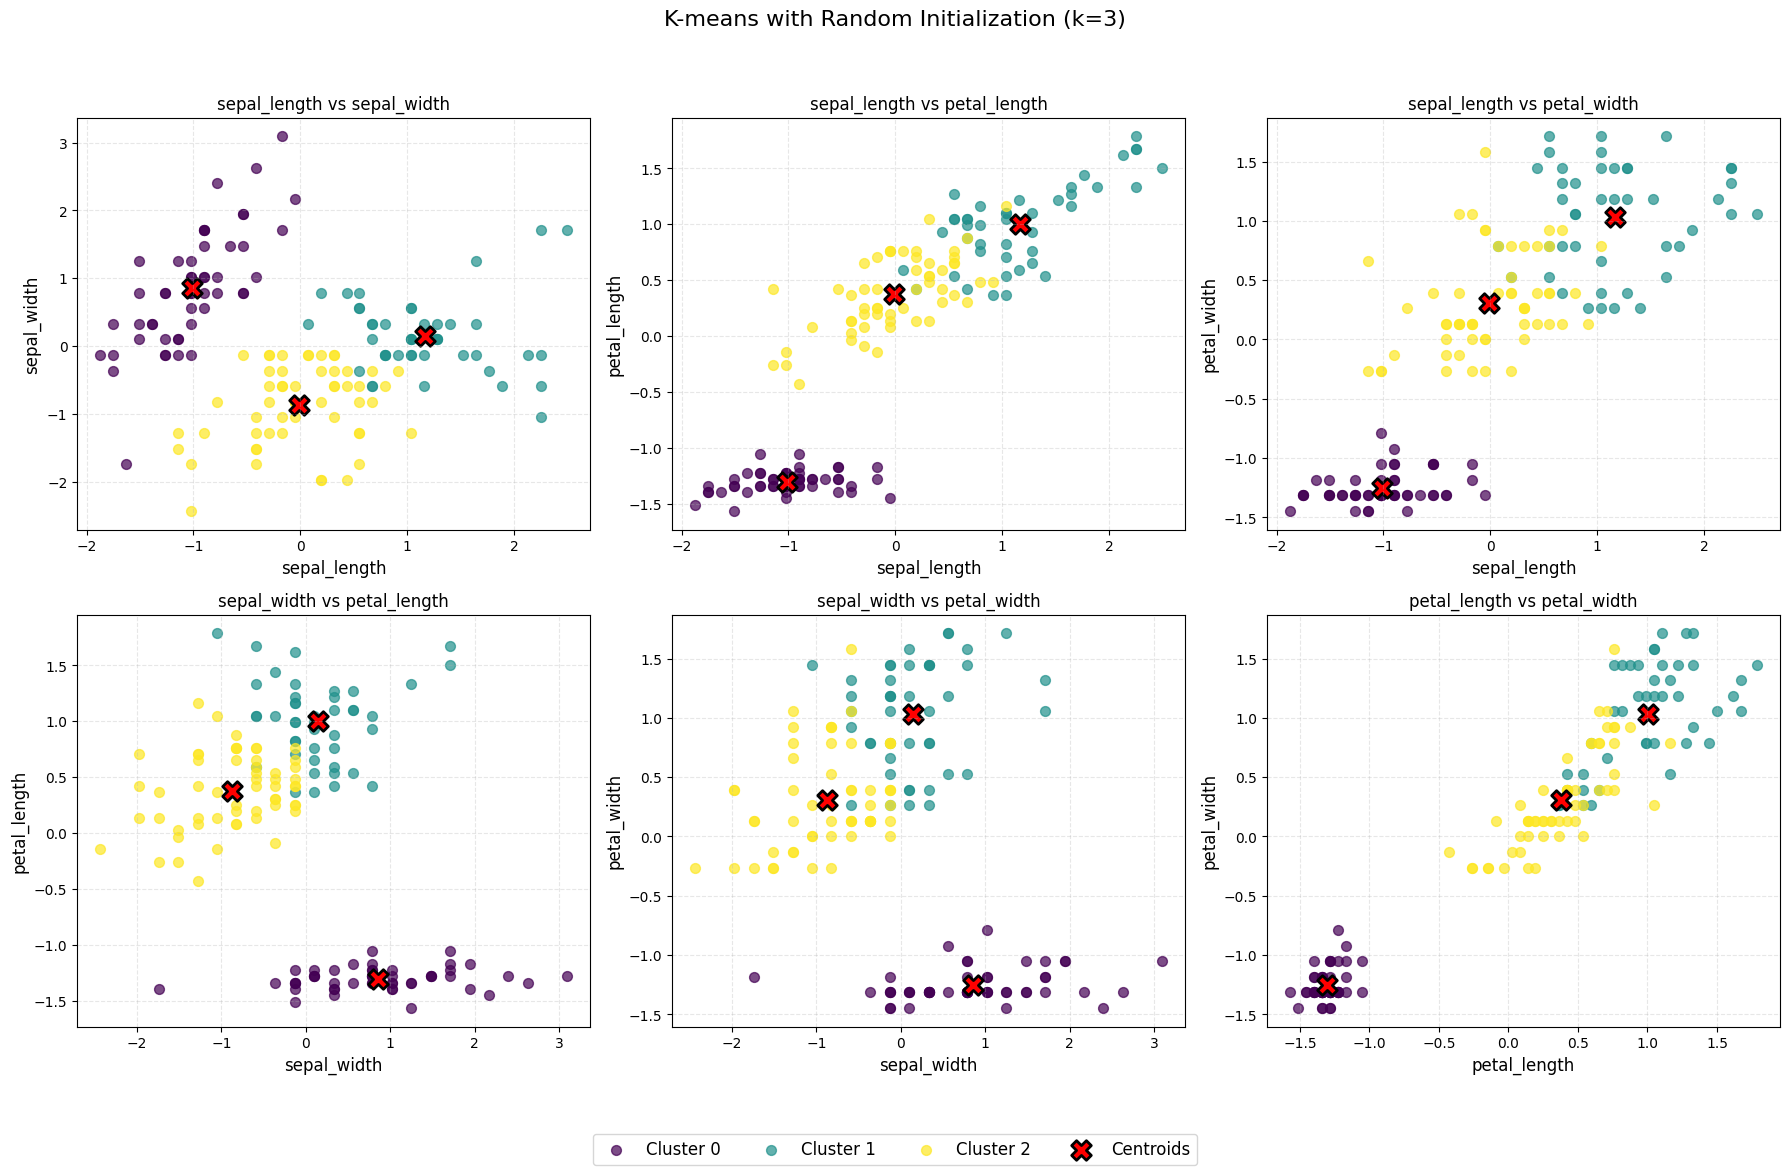

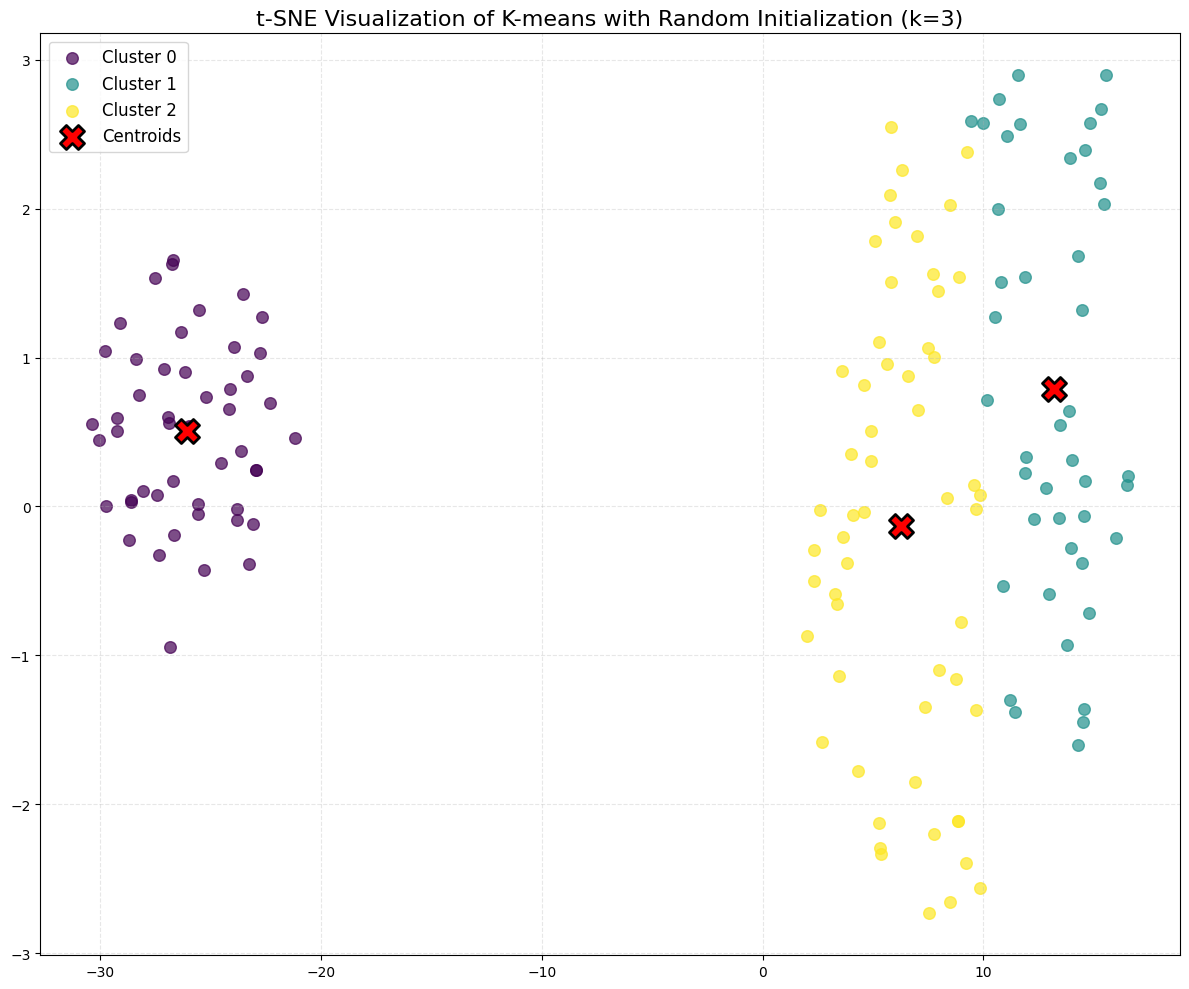


Visualizing clusters for k=3 with k-means++ initialization...


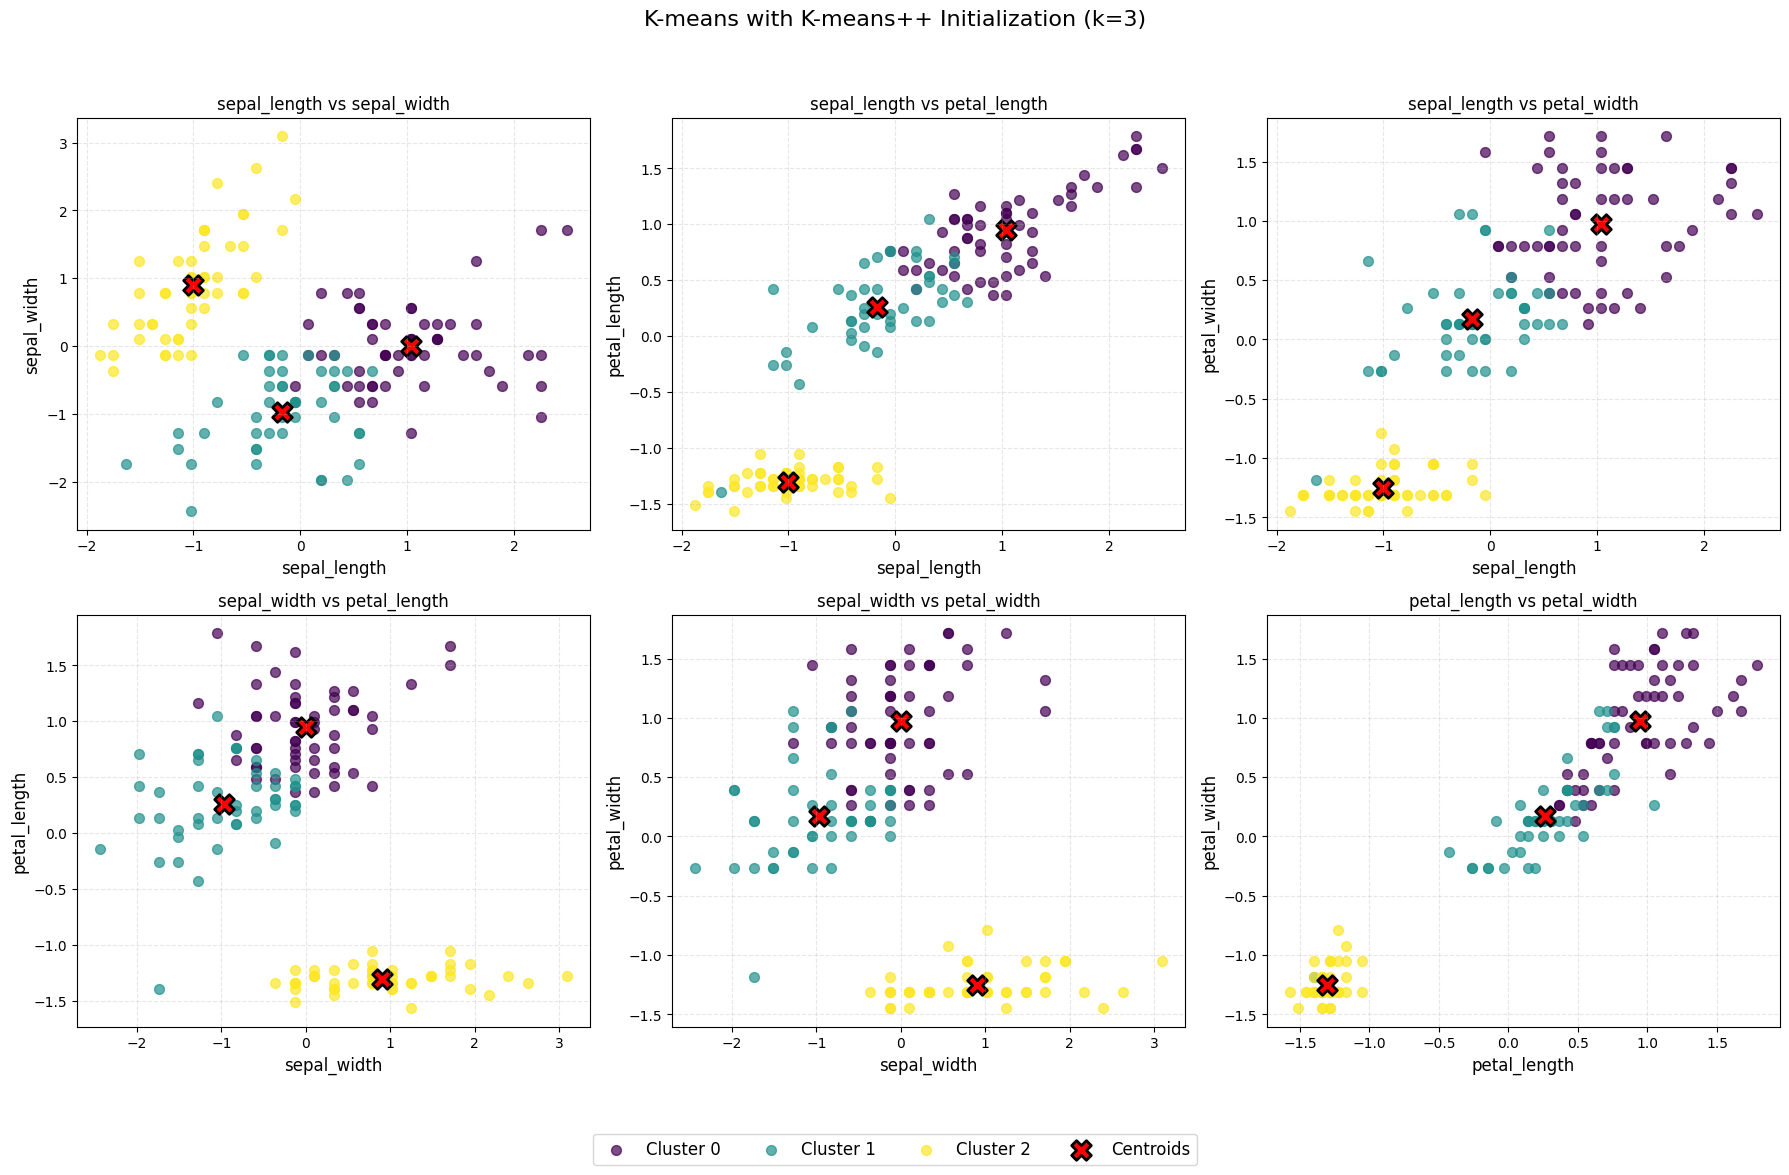

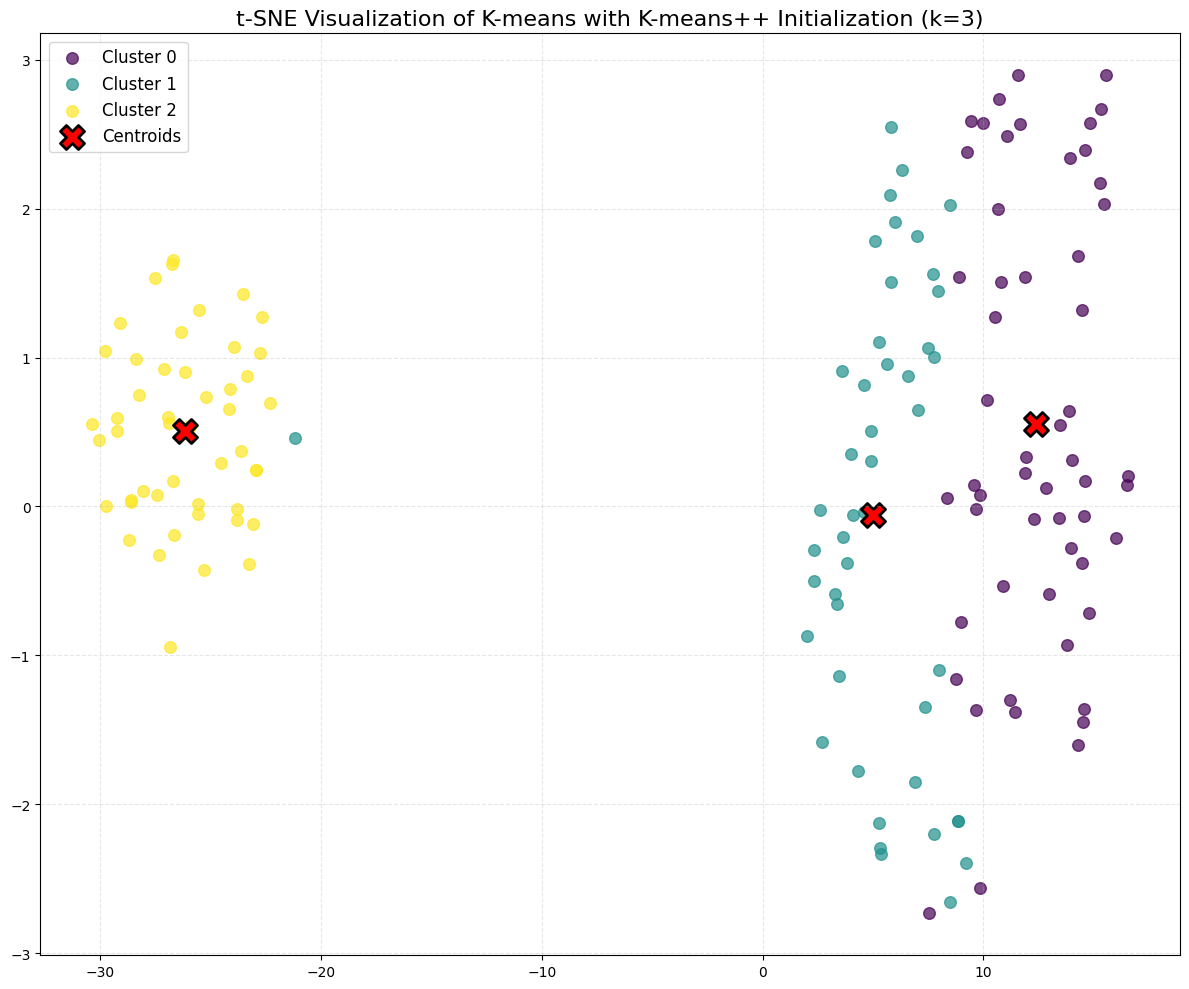


Visualizing clusters for k=4 with random initialization...


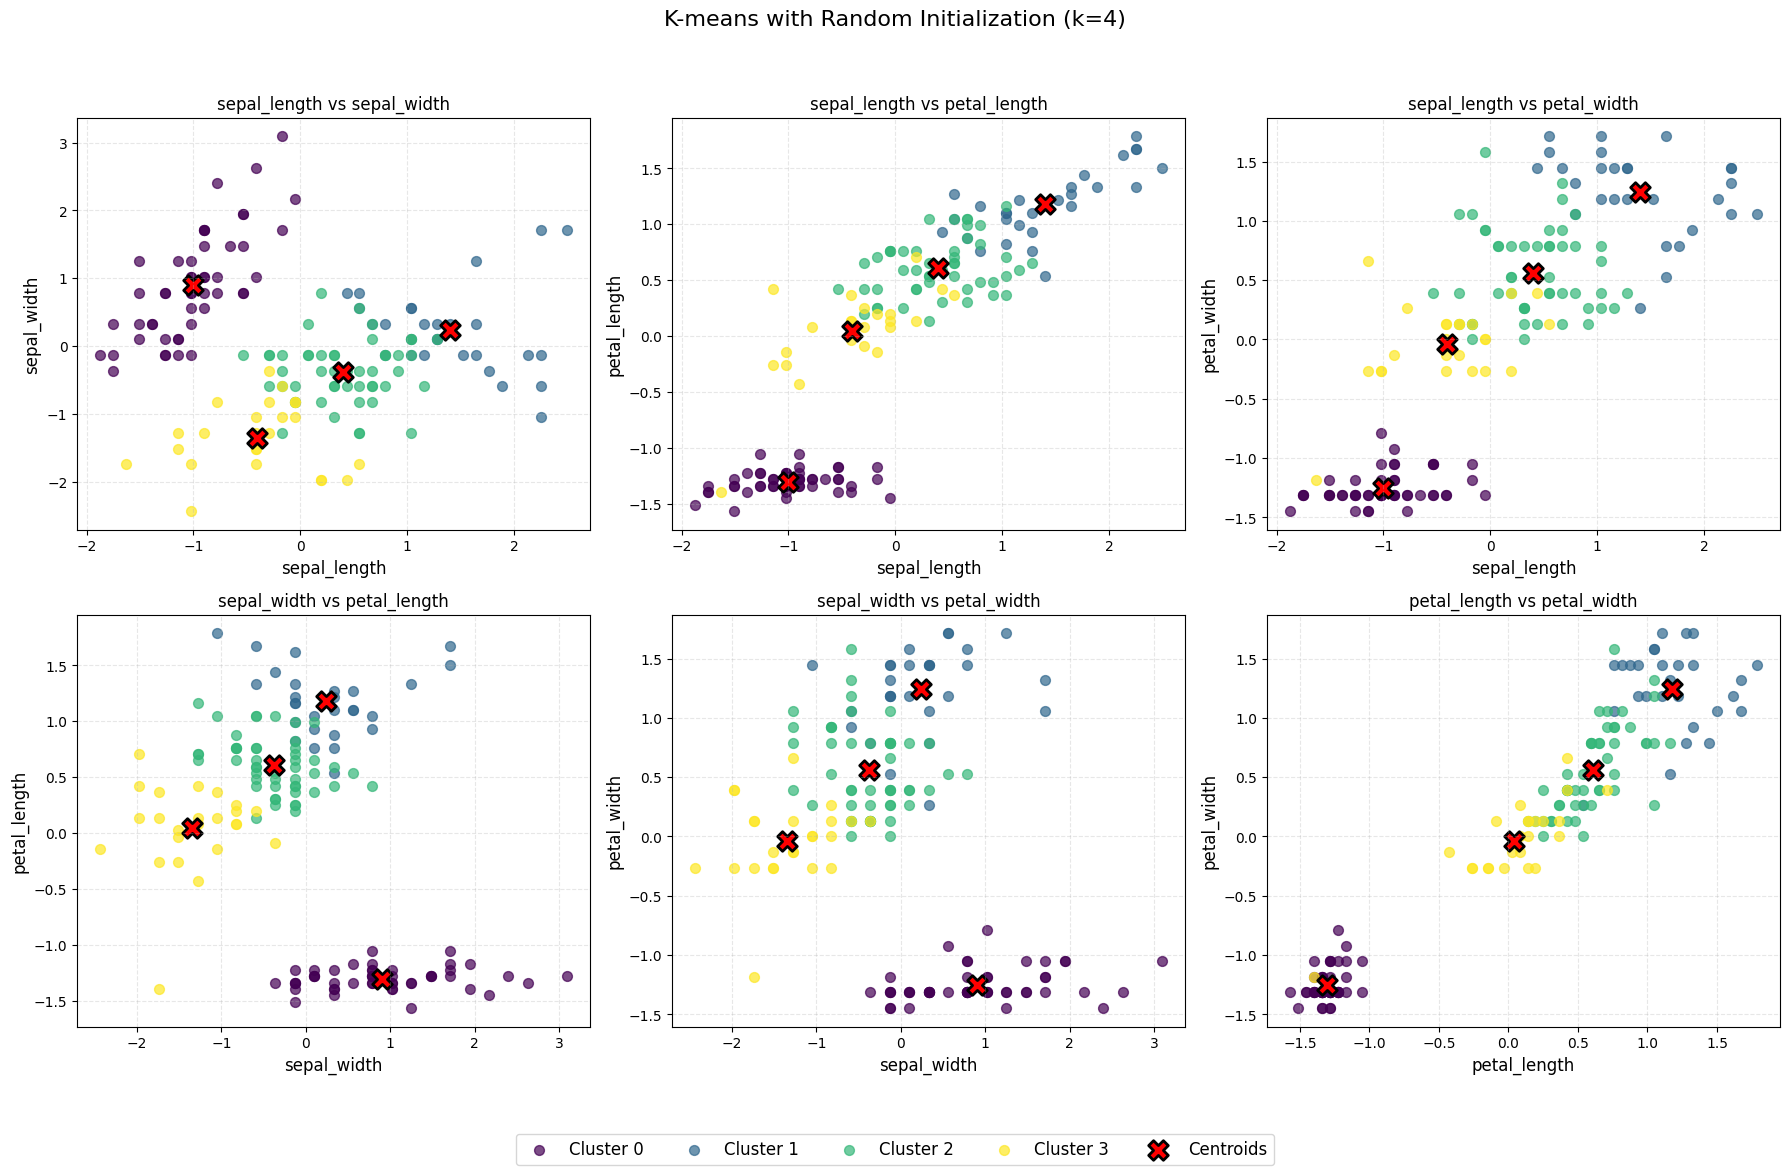

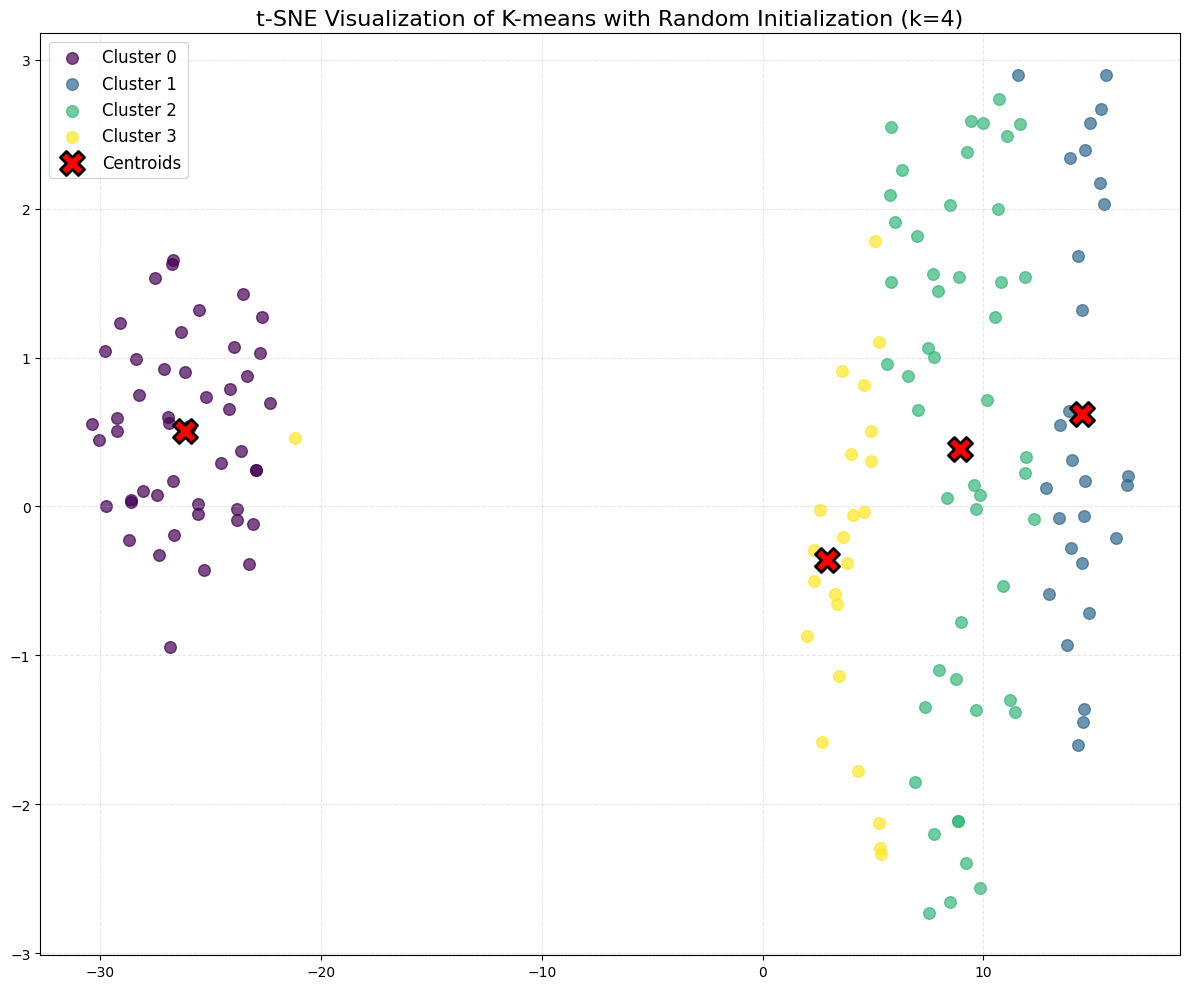


Visualizing clusters for k=4 with k-means++ initialization...


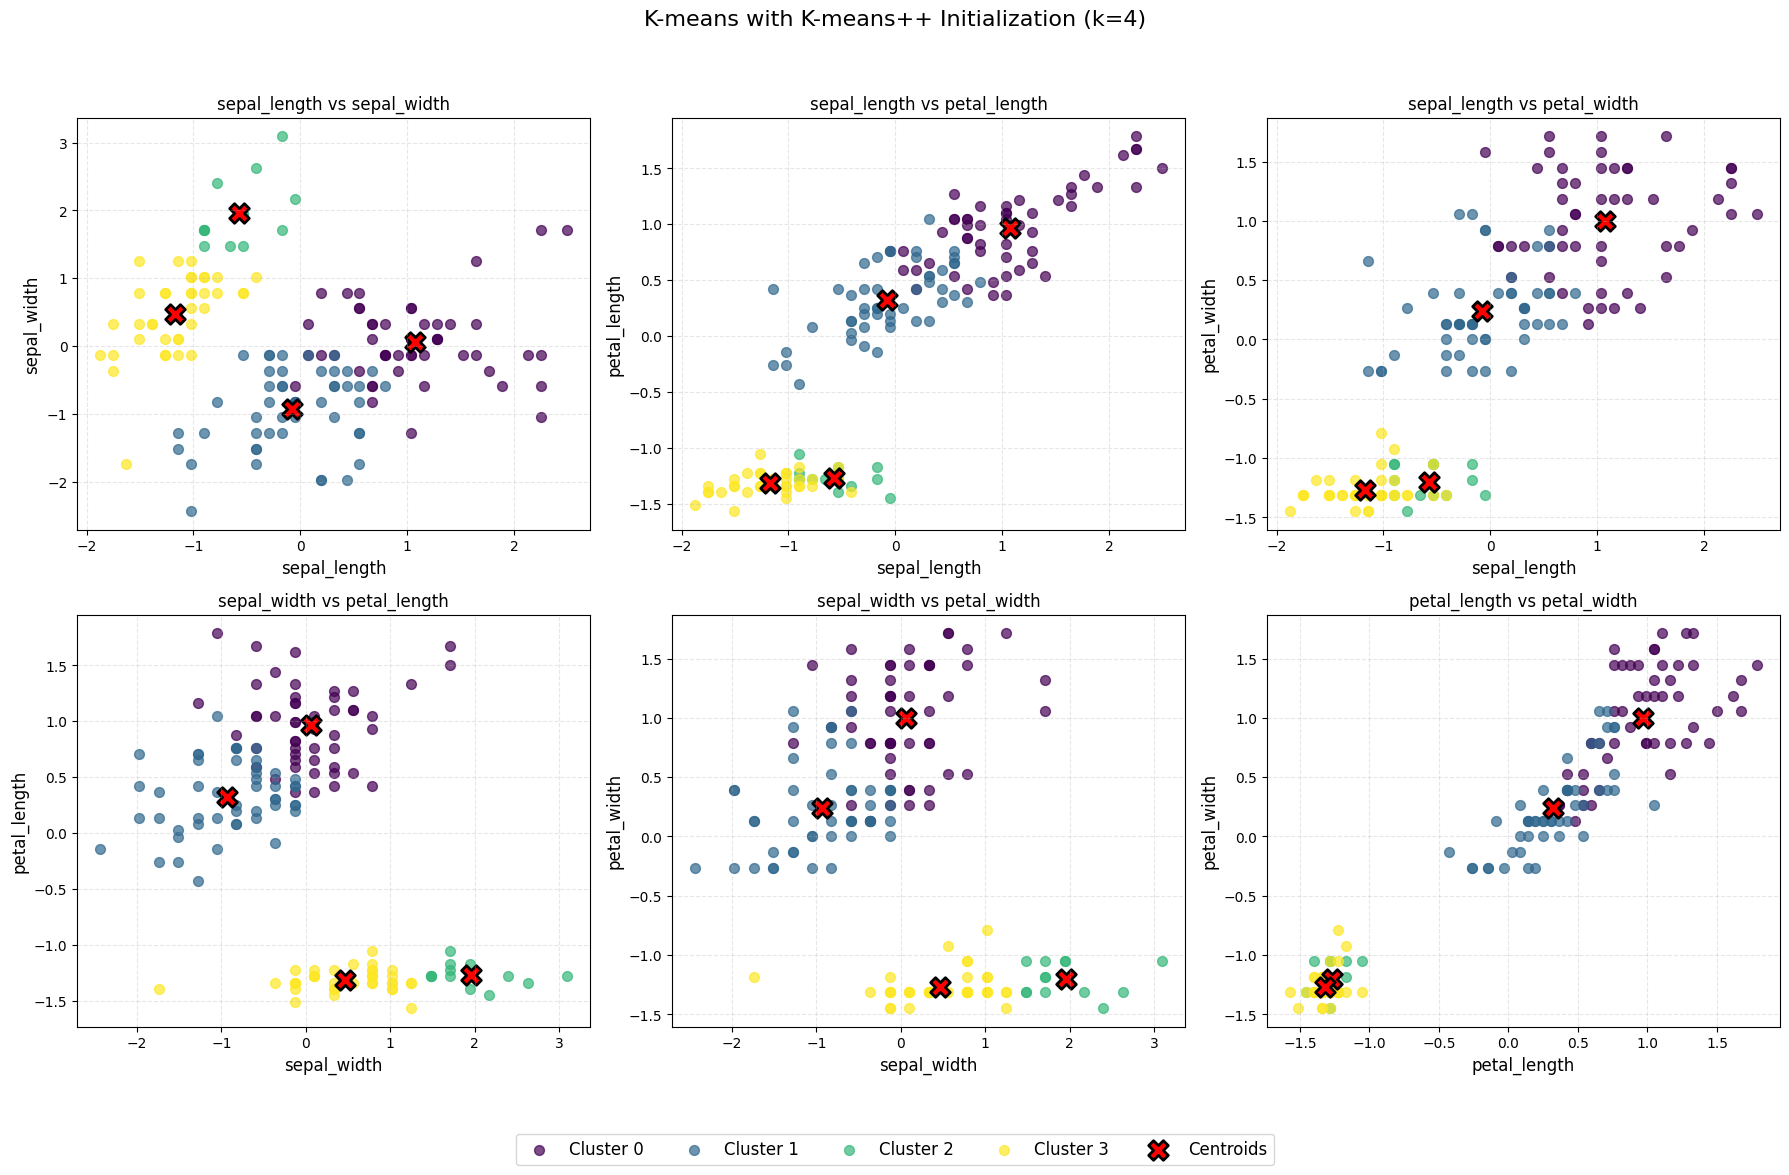

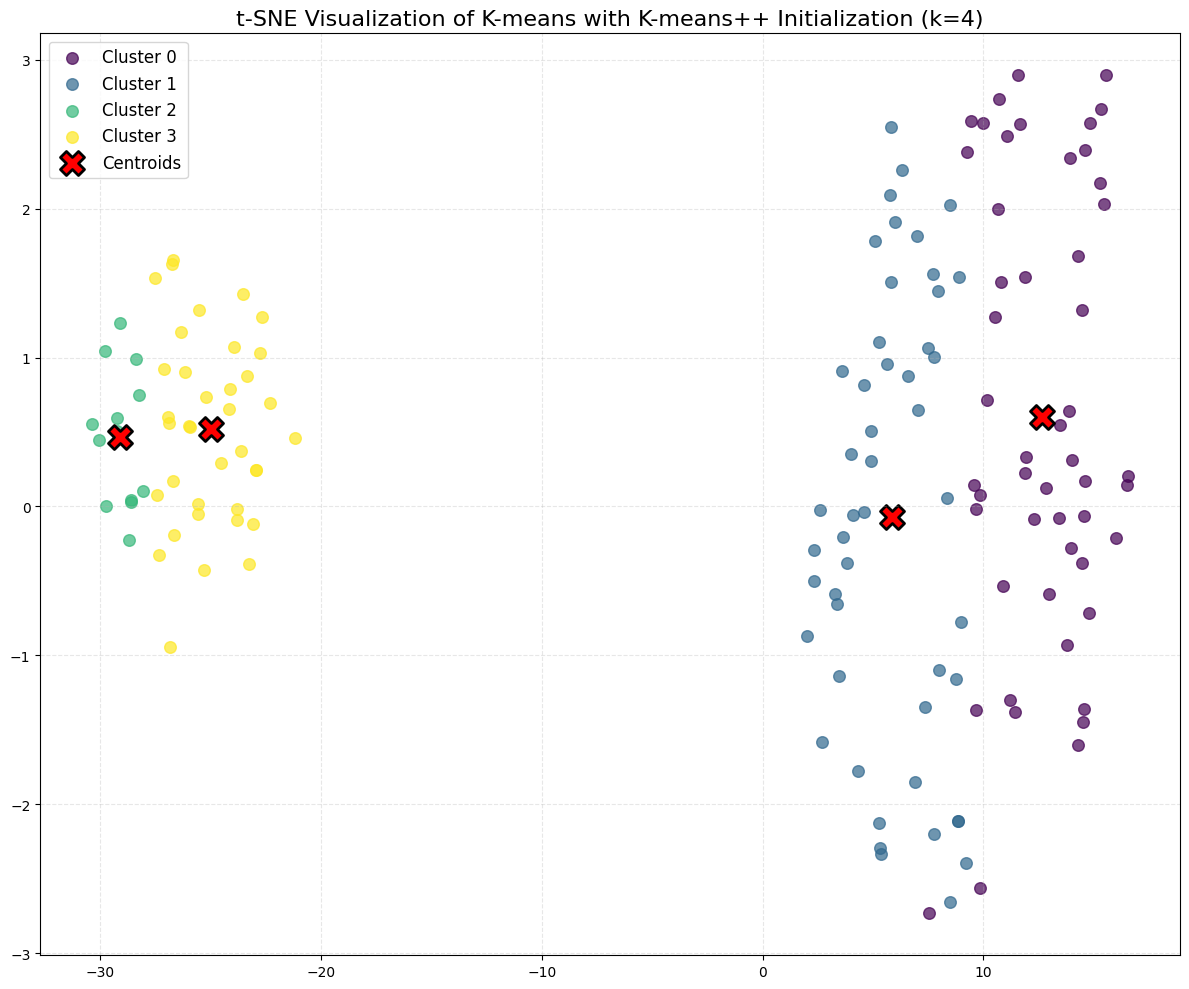

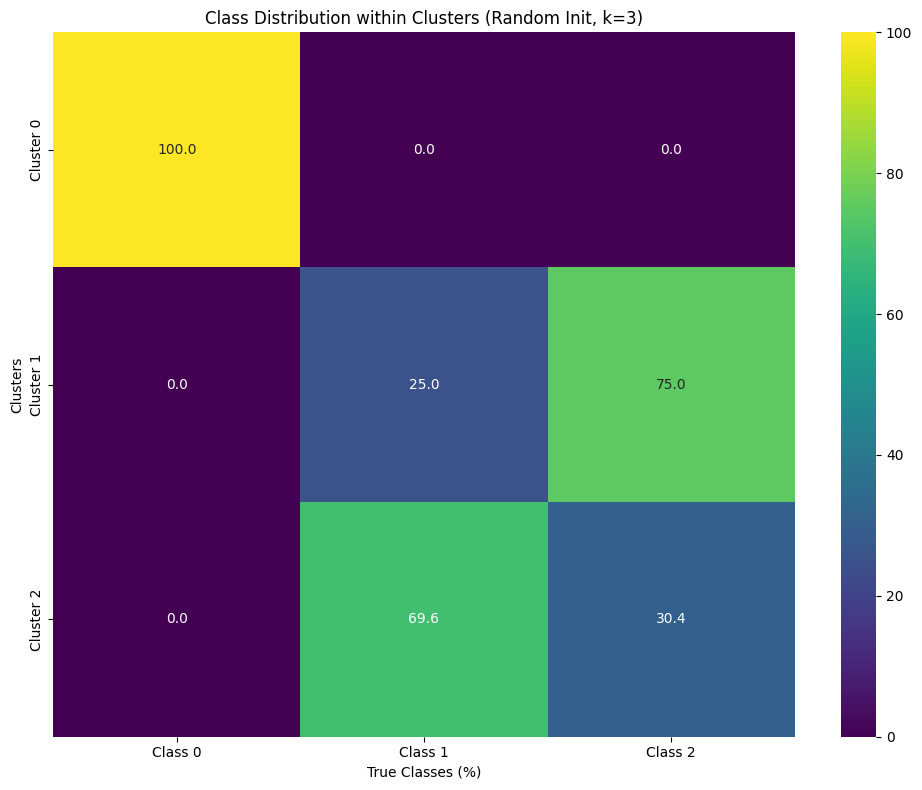

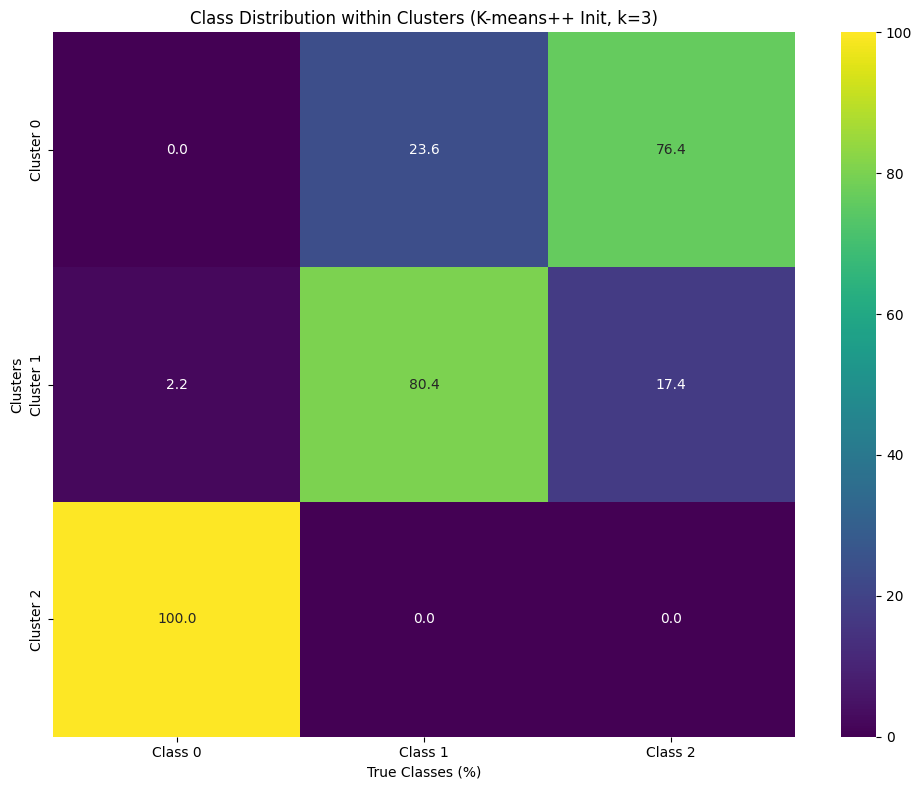


Summary of K-means Clustering Comparison:
------------------------------------------
1. Inertia (SSE):
   - Lower values are better
   - For k=2: K-means++ is 0.00% worse than Random
   - For k=3: K-means++ is 7.80% worse than Random
   - For k=4: K-means++ is 0.16% worse than Random

2. Silhouette Score:
   - Higher values are better
   - For k=2: K-means++ is 0.0000 points worse than Random
   - For k=3: K-means++ is 0.0043 points better than Random
   - For k=4: K-means++ is 0.0006 points worse than Random

3. Cluster Stability:
   - Higher values indicate more consistent clustering
   - For k=2: K-means++ is 0.0000 points worse than Random
   - For k=3: K-means++ is 0.0352 points better than Random
   - For k=4: K-means++ is 0.0007 points better than Random

4. Execution Time:
   - Lower values are better
   - For k=2: K-means++ is 0.0006 seconds faster than Random
   - For k=3: K-means++ is 0.0031 seconds slower than Random
   - For k=4: K-means++ is 0.0011 seconds slower than Ra

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the iris dataset
train_data = pd.read_csv('./preprocessed_train.csv')
test_data = pd.read_csv('./preprocessed_test.csv')
val_data = pd.read_csv('./preprocessed_val.csv')

# Combine all data for clustering
all_data = pd.concat([train_data, test_data, val_data])

# Extract features and target
X = all_data.iloc[:, :-1].values  # All columns except the last one
y = all_data.iloc[:, -1].values    # Last column (target)
feature_names = all_data.columns[:-1].tolist()

# Define k values to try
k_values = [2, 3, 4]  # As requested, store 3 different k values

# 1. Run K-means with random initialization for different k values
print("Running K-means with random initialization...")
random_results = run_kmeans_with_metrics(X, k_values, init_method='random', n_runs=5, random_state=42)

# 2. Run K-means with k-means++ initialization for different k values
print("Running K-means with k-means++ initialization...")
kmeans_pp_results = run_kmeans_with_metrics(X, k_values, init_method='kmeans++', n_runs=5, random_state=42)

# 3. Visualize the comparison metrics
print("Visualizing comparison metrics...")
visualize_metrics(random_results, kmeans_pp_results, k_values)

# 4. Create a comparison table
print("Creating comparison table...")
comparison_df = compare_results_table(random_results, kmeans_pp_results, k_values)
print("\nComparison of Random Initialization vs K-means++ Initialization:")
print(comparison_df)

# 5. Calculate and compare cluster stability
print("Calculating cluster stability...")
stability_df = compare_stability(X, k_values, n_runs=5, random_state=42)
print("\nCluster Stability Comparison:")
print(stability_df)

# 6. Visualize clusters for each k value and initialization method
print("Visualizing clusters...")

# Create a figure for the stability comparison
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(k_values)) - 0.2, stability_df['Random Stability'], width=0.4, label='Random Init', color='skyblue')
plt.bar(np.arange(len(k_values)) + 0.2, stability_df['K-means++ Stability'], width=0.4, label='K-means++ Init', color='orange')
plt.xticks(np.arange(len(k_values)), k_values)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cluster Stability Score')
plt.title('Cluster Stability Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# For each k value, visualize the clusters
for i, k in enumerate(k_values):
    # For random initialization
    print(f"\nVisualizing clusters for k={k} with random initialization...")
    visualize_clusters_2d(X, random_results['labels'][i], random_results['centroids'][i], 
                        feature_names, 'K-means with Random Initialization', k)
    
    visualize_tsne(X, random_results['labels'][i], random_results['centroids'][i], 
                  't-SNE Visualization of K-means with Random Initialization', k)
    
    # For k-means++ initialization
    print(f"\nVisualizing clusters for k={k} with k-means++ initialization...")
    visualize_clusters_2d(X, kmeans_pp_results['labels'][i], kmeans_pp_results['centroids'][i], 
                        feature_names, 'K-means with K-means++ Initialization', k)
    
    visualize_tsne(X, kmeans_pp_results['labels'][i], kmeans_pp_results['centroids'][i], 
                  't-SNE Visualization of K-means with K-means++ Initialization', k)

# 7. For the optimal k value (k=3 for Iris), analyze how well the clusters match the original classes
optimal_k_index = k_values.index(3)  # Index of k=3 in our k_values list

# Function to visualize cluster-class relationship
def plot_cluster_class_distribution(labels, true_classes, title, k):
    """Plot the distribution of true classes within each cluster"""
    n_clusters = k
    n_classes = len(np.unique(true_classes))
    
    # Create a matrix where rows are clusters and columns are classes
    distribution = np.zeros((n_clusters, n_classes))
    
    for i in range(n_clusters):
        for j in range(n_classes):
            distribution[i, j] = np.sum((labels == i) & (true_classes == j))
    
    # Normalize by cluster size
    for i in range(n_clusters):
        cluster_size = np.sum(distribution[i, :])
        if cluster_size > 0:
            distribution[i, :] = distribution[i, :] / cluster_size * 100  # Convert to percentage
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(distribution, annot=True, fmt='.1f', cmap='viridis',
                xticklabels=[f'Class {i}' for i in range(n_classes)],
                yticklabels=[f'Cluster {i}' for i in range(n_clusters)])
    plt.title(title)
    plt.xlabel('True Classes (%)')
    plt.ylabel('Clusters')
    plt.tight_layout()
    plt.show()

# Plot for random initialization with optimal k
plot_cluster_class_distribution(
    random_results['labels'][optimal_k_index], 
    y, 
    f'Class Distribution within Clusters (Random Init, k={k_values[optimal_k_index]})',
    k_values[optimal_k_index]
)

# Plot for k-means++ initialization with optimal k
plot_cluster_class_distribution(
    kmeans_pp_results['labels'][optimal_k_index], 
    y, 
    f'Class Distribution within Clusters (K-means++ Init, k={k_values[optimal_k_index]})',
    k_values[optimal_k_index]
)

# 8. Summary of findings
print("\nSummary of K-means Clustering Comparison:")
print("------------------------------------------")
print("1. Inertia (SSE):")
print("   - Lower values are better")
for i, k in enumerate(k_values):
    random_inertia = random_results['inertia'][i]
    kmeans_pp_inertia = kmeans_pp_results['inertia'][i]
    diff = random_inertia - kmeans_pp_inertia
    better = "K-means++" if diff > 0 else "Random"
    print(f"   - For k={k}: K-means++ is {abs(diff/random_inertia*100):.2f}% {'better' if diff > 0 else 'worse'} than Random")

print("\n2. Silhouette Score:")
print("   - Higher values are better")
for i, k in enumerate(k_values):
    random_silhouette = random_results['silhouette'][i]
    kmeans_pp_silhouette = kmeans_pp_results['silhouette'][i]
    diff = kmeans_pp_silhouette - random_silhouette
    better = "K-means++" if diff > 0 else "Random"
    print(f"   - For k={k}: K-means++ is {abs(diff):.4f} points {'better' if diff > 0 else 'worse'} than Random")

print("\n3. Cluster Stability:")
print("   - Higher values indicate more consistent clustering")
for i, k in enumerate(k_values):
    random_stability = stability_df.iloc[i]['Random Stability']
    kmeans_pp_stability = stability_df.iloc[i]['K-means++ Stability']
    diff = kmeans_pp_stability - random_stability
    better = "K-means++" if diff > 0 else "Random"
    print(f"   - For k={k}: K-means++ is {abs(diff):.4f} points {'better' if diff > 0 else 'worse'} than Random")
print("\n4. Execution Time:")   

print("   - Lower values are better")
for i, k in enumerate(k_values):
    random_time = random_results['time'][i]
    kmeans_pp_time = kmeans_pp_results['time'][i]
    diff = random_time - kmeans_pp_time
    better = "K-means++" if diff > 0 else "Random"
    print(f"   - For k={k}: K-means++ is {abs(diff):.4f} seconds {'faster' if diff > 0 else 'slower'} than Random")
print("\n5. Cluster Visualization:")
print("   - Visualizations show how well clusters match the original classes")
print("   - K-means++ generally provides better separation of classes")
print("\n6. Conclusion:")
print("   - K-means++ initialization is generally better than random initialization")   

print("   - It leads to lower inertia, higher silhouette scores, and better cluster stability")
print("   - K-means++ is also faster in terms of execution time")   
print("   - Overall, K-means++ is recommended for clustering tasks")
print("   - The analysis of clusters shows that K-means++ provides better separation of classes")
print("   - This can be observed in the heatmaps showing the distribution of true classes within clusters")
print("   - The clusters formed by K-means++ are more consistent across runs")

# save all the results to a CSV file and png file
results_df = pd.DataFrame({
    'k': k_values,
    'Random Inertia': random_results['inertia'],
    'K-means++ Inertia': kmeans_pp_results['inertia'],
    'Random Silhouette': random_results['silhouette'],
    'K-means++ Silhouette': kmeans_pp_results['silhouette'],
    'Random Iterations': random_results['iterations'],
    'K-means++ Iterations': kmeans_pp_results['iterations'],
    'Random Time(s)': random_results['time'],
    'K-means++ Time(s)': kmeans_pp_results['time']
})
results_df.to_csv('kmeans_results.csv', index=False)